In [4]:
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
# !pip install numpy matplotlib

In [5]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms

from torch.utils.data.sampler import SubsetRandomSampler

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [7]:
def get_train_valid_loader(data_dir, batch_size, augment, random_seed, valid_size=0.1, shuffle=True):
    
    # normalization values from https://github.com/Lornatang/AlexNet-PyTorch/blob/main/dataset.py

    if augment:
        train_transform = transforms.Compose(
            [
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]
        )
    else:
        train_transform = transforms.Compose(
            [
                transforms.Resize((227, 227)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]
        )

    # define transforms
    valid_transform = transforms.Compose(
        [
            transforms.Resize((227, 227)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    )

    # load the dataset
    train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_transform)
    valid_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=valid_transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_sampler = SubsetRandomSampler(valid_idx)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)

In [8]:
def get_test_loader(data_dir, batch_size, shuffle=True):

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return data_loader

In [9]:
# CIFAR10 dataset 
train_loader, valid_loader = get_train_valid_loader(data_dir = './data', batch_size = 64, augment=False, random_seed = 1)

test_loader = get_test_loader(data_dir = './data', batch_size = 64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1834, 1834)


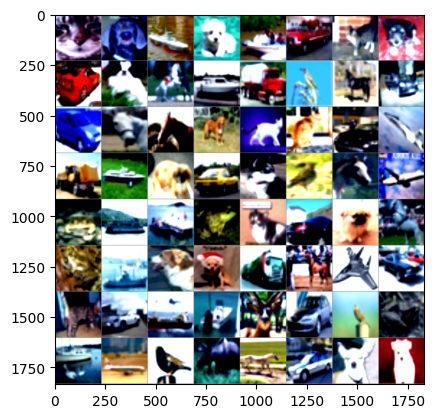

tensor([3, 5, 8, 5, 8, 9, 3, 5, 1, 5, 7, 8, 9, 2, 7, 1, 1, 7, 7, 5, 3, 3, 1, 0,
        9, 8, 5, 1, 5, 2, 7, 0, 6, 8, 8, 6, 3, 1, 5, 7, 6, 8, 5, 5, 9, 7, 0, 1,
        3, 1, 8, 8, 4, 1, 2, 6, 8, 0, 2, 4, 7, 1, 5, 5])


In [10]:
# display the image
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


import torchvision

for i, (images, labels) in enumerate(train_loader):
    imshow(torchvision.utils.make_grid(images))
    print(labels)
    break

In [11]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0), nn.ReLU(), nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Flatten(),
            nn.Dropout(0.5), nn.Linear(9216, 4096), nn.ReLU(), # 256 * 6 * 6, 4096
            nn.Dropout(0.5), nn.Linear(4096, 4096), nn.ReLU(), 
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

In [12]:
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.005

momentum = 0.9
weight_decay = 0.005

model = AlexNet(num_classes).to(device)
model.eval()

AlexNet(
  (model): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=9216, out_features=4096, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=4096, out_features=4096, bias=Tr

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

In [14]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

Epoch [1/20], Step [704/704], Loss: 1.1138
Accuracy of the network on the 5000 validation images: 43.54 %
Epoch [2/20], Step [704/704], Loss: 2.1468
Accuracy of the network on the 5000 validation images: 52.94 %
Epoch [3/20], Step [704/704], Loss: 1.4225
Accuracy of the network on the 5000 validation images: 59.06 %
Epoch [4/20], Step [704/704], Loss: 1.1774
Accuracy of the network on the 5000 validation images: 67.14 %
Epoch [5/20], Step [704/704], Loss: 0.2977
Accuracy of the network on the 5000 validation images: 66.52 %
Epoch [6/20], Step [704/704], Loss: 1.4316
Accuracy of the network on the 5000 validation images: 71.98 %
Epoch [7/20], Step [704/704], Loss: 0.3382
Accuracy of the network on the 5000 validation images: 70.46 %
Epoch [8/20], Step [704/704], Loss: 0.5193
Accuracy of the network on the 5000 validation images: 76.18 %
Epoch [9/20], Step [704/704], Loss: 0.2313
Accuracy of the network on the 5000 validation images: 75.04 %
Epoch [10/20], Step [704/704], Loss: 0.5557
Ac

In [15]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

Accuracy of the network on the 10000 test images: 77.26 %
